In [ ]:
import os

import glob
import math
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import scipy
from scipy.ndimage import gaussian_filter, binary_fill_holes
from skimage import morphology

from skimage.segmentation import (
    morphological_chan_vese,
    checkerboard_level_set,
)

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def dice_coefficient(im1, im2):
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [3]:
def load_images(files, resize=(256,256)):
    images = []
    for file in files:
        im = Image.open(file)
        im = ImageOps.exif_transpose(im)
        if resize:
            im = im.resize(resize)
        im = im.convert('L')
        images.append(np.array(im))
    return np.array(images)

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [5]:
mode = ['images', 'masks']
BASE_PATH_IMGS = os.path.join('data', mode[0])
BASE_PATH_MASKS = os.path.join('data', mode[1])
BASE_OUTPUT_PATH = os.path.join('outputs')
files = sorted(glob.glob(os.path.join(BASE_PATH_IMGS, '*')))
files_masks = sorted(glob.glob(os.path.join(BASE_PATH_MASKS, '*')))

In [44]:
def run_exp_evaluation(segmentations, resizes):
    # Load Data
    resize = [int(resizes.split('x')[0]), int(resizes.split('x')[1])]
    files_masks_pred_snakes = sorted(glob.glob(os.path.join(BASE_OUTPUT_PATH, segmentations, resizes, '*')))
    images = load_images(files, resize)
    masks = load_images(files_masks, resize)
    masks_pred_snakes = load_images(files_masks_pred_snakes, resize)

    # Binarize Data
    masks = masks > 0.5
    masks_pred_snakes = masks_pred_snakes > 0.5

    # Calculate dice for all masks and gts
    dice = []
    for i in range(len(masks)):
        dice.append(dice_coefficient(masks[i], masks_pred_snakes[i]))

    print(f'Dice coefficient for {segmentations}: {np.mean(dice)}')

    # Segmentation vs Ground Truth, best case, average case, worst case

    cases = ['best_case', 'worst_case', 'average_case']
    idxs = [np.argmax(dice), np.argmin(dice), np.argwhere(np.array(dice) == find_nearest(np.array(dice), np.mean(dice))).flatten()[0]]

    fig = plt.figure(figsize=(16, 9))

    for j, i in enumerate(idxs):
        plt.subplot(3, 2, 2*j+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Image {cases[j]}')
        plt.axis('off')

        plt.subplot(3, 2, 2*j+2)
        mask = masks_pred_snakes[i].astype('uint8')
        mask_line = mask - morphology.erosion(mask, morphology.square(3))
        plt.imshow(masks[i], cmap='gray')
        plt.contour(mask, alpha=0.5, colors=['r'])
        plt.title(f'Ground Truth vs Segmentation. Dice: {dice[i]:.4f}')
        plt.axis('off')

    plt.show()

    # Boxplot
    fig = plt.figure(figsize=(16, 9))
    plt.boxplot(dice, vert=True)
    plt.title('Dice Coefficient')
    plt.show()

    # Error for all imagens in half violin plot half boxplot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.violinplot(data=dice, inner=None, linewidth=0, ax=ax, cut=0)
    sns.boxplot(data=dice, width=0.2, whis=0, linewidth=2, ax=ax)
    plt.title(f'Dice coefficient for {segmentations}')

    for i, patch in enumerate(ax.collections[:len(dice)]):
        x_center = i
        patch.set_clip_path(Polygon([[x_center - 0.5, -10], [x_center, -10], [x_center, 10], [x_center - 0.5, 10]], closed=True, transform=ax.transData))

    # Final touches
    plt.title("Half Boxplot, Half Violin Plot")
    plt.ylabel("Dice Coefficient")
    plt.show()

    # Error Values in Histogram
    fig = plt.figure(figsize=(10, 5))
    plt.hist(dice, bins=20)
    plt.title('Dice Coefficient Histogram')
    plt.show()

Dice coefficient for segmentation_snakes: 0.6225145699631459


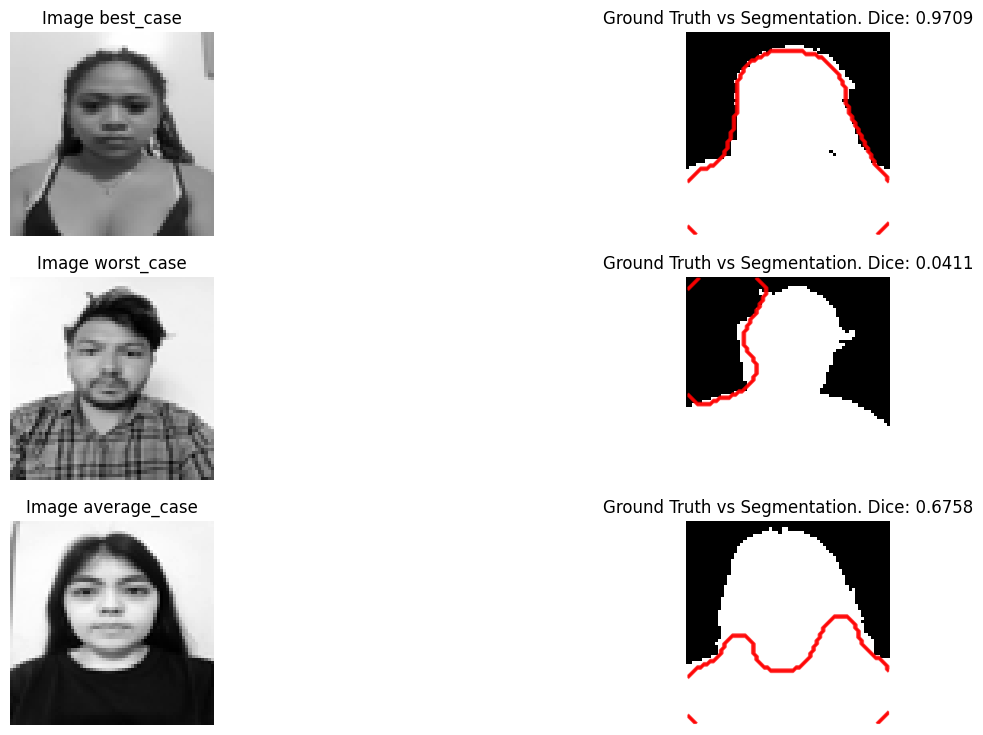

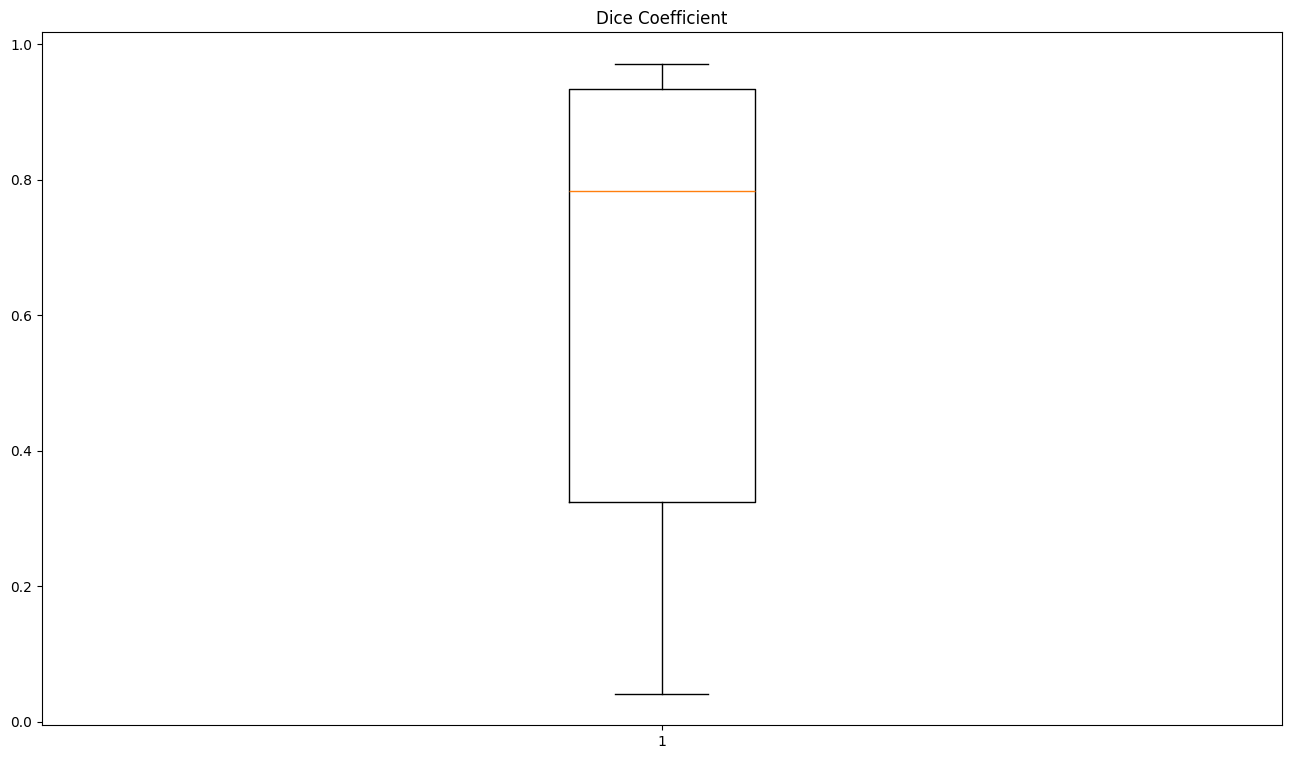

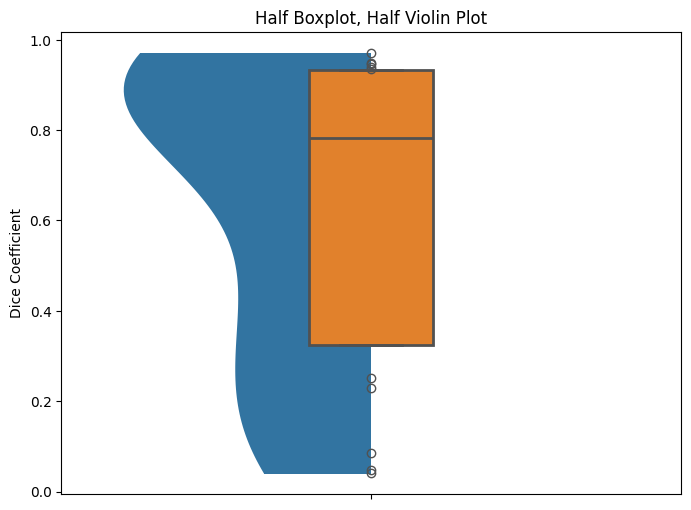

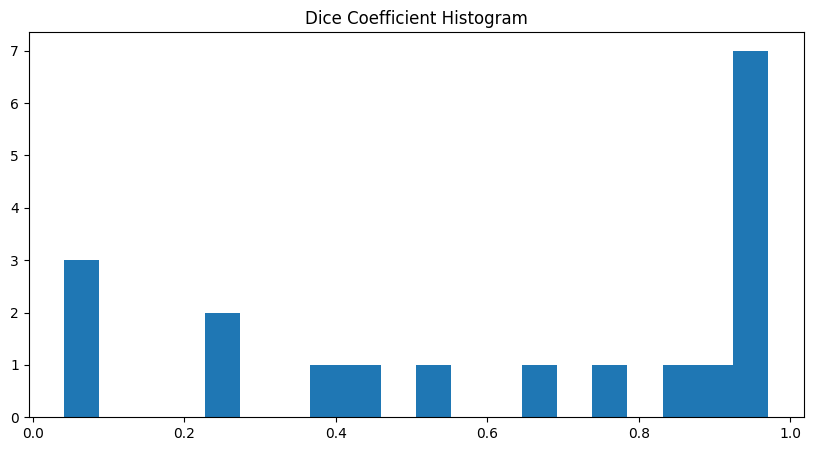

In [45]:
run_exp_evaluation('segmentation_snakes', '64x64')

In [ ]:
run_exp_evaluation('segmentation_snakes', '256x256')

In [ ]:
run_exp_evaluation('segmentation_snakes', '1024x1024')

In [ ]:
run_exp_evaluation('segmentation_otsu', '64x64')

In [ ]:
run_exp_evaluation('segmentation_otsu', '256x256')

In [ ]:
run_exp_evaluation('segmentation_otsu', '1024x1024')

In [ ]:
run_exp_evaluation('segmentation_quad_tree', '64x64')

In [ ]:
run_exp_evaluation('segmentation_quad_tree', '256x256')

In [ ]:
run_exp_evaluation('segmentation_quad_tree', '1024x1024')

In [ ]:
# Compare the results of the three methods for the three image sizes
# Boxplot
segmentations = ['segmentation_snakes', 'segmentation_otsu', 'segmentation_quad_tree']
resizes = ['64x64', '256x256', '1024x1024']
dices = []
d = {}

for res in resizes:
    images = load_images(files, [int(res.split('x')[0]), int(res.split('x')[1])])
    masks = load_images(files_masks, [int(res.split('x')[0]), int(res.split('x')[1])])
    for segmentation in segmentations:
        files_masks_pred_snakes = sorted(glob.glob(os.path.join(BASE_OUTPUT_PATH, segmentation, res, '*')))
        masks_pred_snakes = load_images(files_masks_pred_snakes, [int(res.split('x')[0]), int(res.split('x')[1])])

        masks = masks > 0.5
        masks_pred_snakes = masks_pred_snakes > 0.5

        dice = []
        for i in range(len(masks)):
            dice.append(dice_coefficient(masks[i], masks_pred_snakes[i]))

        key = f"{' '.join(segmentation.split('_')).title()} {res}"
        dices.append(dice)
        d[key] = dice

<Figure size 1600x900 with 0 Axes>

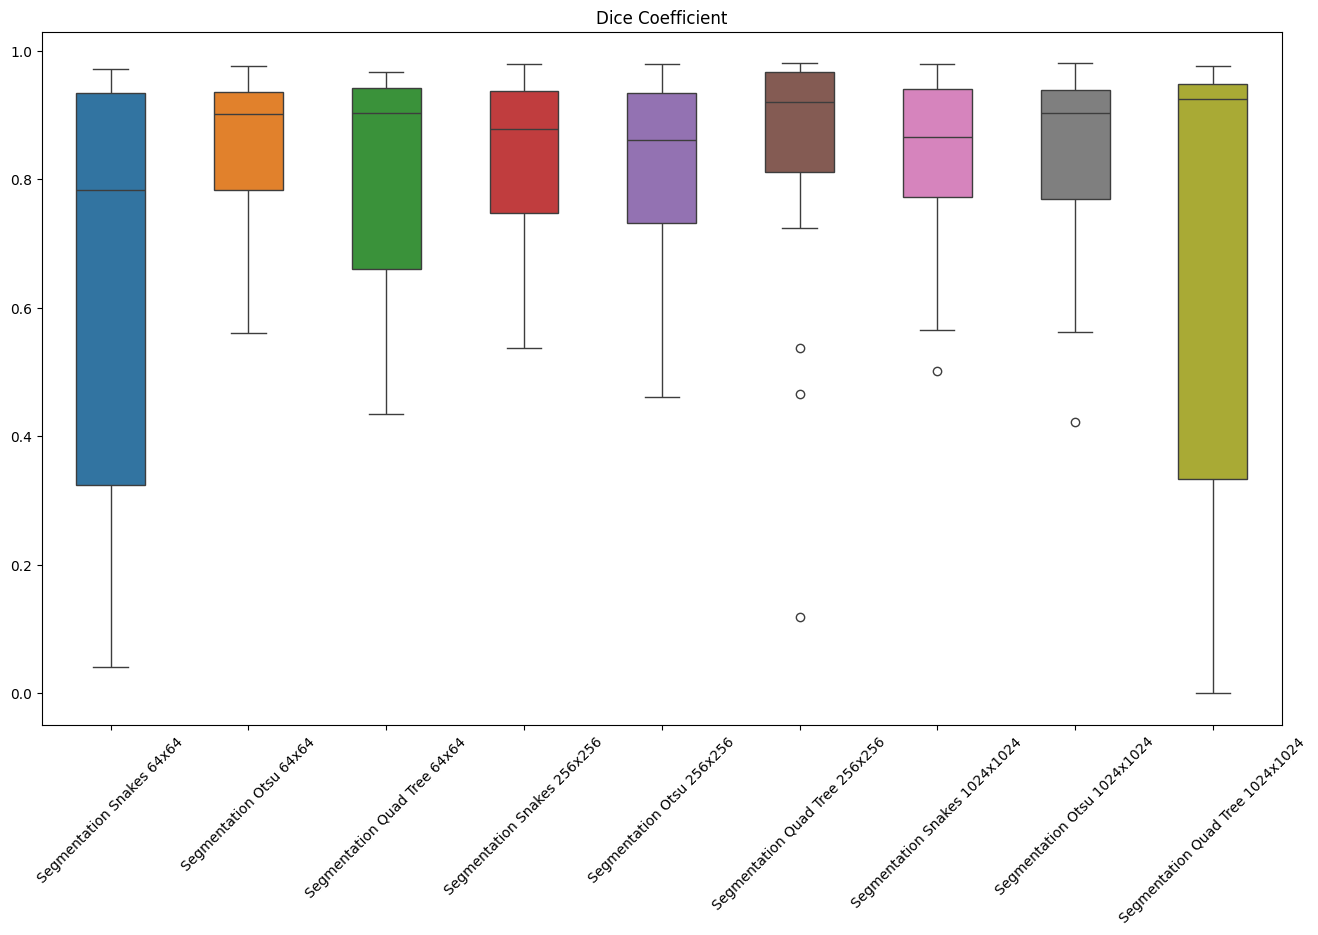

In [28]:
fig = plt.figure(figsize=(16, 9))
sns.boxplot(data=dices, width=0.5)
plt.title('Dice Coefficient')
plt.xticks(list(range(0, len(d.keys()))),list(d.keys()), rotation=45)
plt.show()